In [2]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
import json
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import operator_map_reaction
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [4]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"[[[1, 2, 3, 4]], [[0, 1, 2, 3]]]","[[1, 7, 8, 9]]",glutamate racemase,P56868,5.1.1.3
1,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"[[[5, 7], [0]], [[0, 1, 2]]]","[[5, 6, 7], [0]]",beta-lactamase (Class A),P62593,3.5.2.6
2,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"[[[5, 7], [0]], [[0, 1, 2]]]","[[5, 6, 7], [0]]",beta-lactamase (Class A),P62593,3.5.2.6
3,6,1,NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,[NH2:17][CH:14]([CH2:12][CH2:9][C:6](=[O:10])[...,[#16:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[...,"[[[9, 10], [3, 4, 5, 45, 46, 47]], [[0], [0], ...","[[9, 10], [3, 4, 5, 47]]",glutathione-disulfide reductase,P00390,1.8.1.7
4,7,2,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,[NH2:18][C:17](=[O:19])[c:11]1[cH:16][cH:15][c...,[#6:1]1:[#6:2]:[#6:3]:[#6:4]:[#7+:5]:[#6:6]:1....,"[[[3, 4, 5, 6, 7, 47], [7, 5, 4, 8, 9]], [[0, ...","[[3, 4, 7, 47], [4, 5, 7, 8, 9, 12]]",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42


In [5]:
mm.loc[mm['entry_id'] == 49, 'reaction_center'].iloc[0]

array([array([array([ 1,  8, 10])], dtype=object),
       array([array([0]), array([0, 1])], dtype=object)], dtype=object)

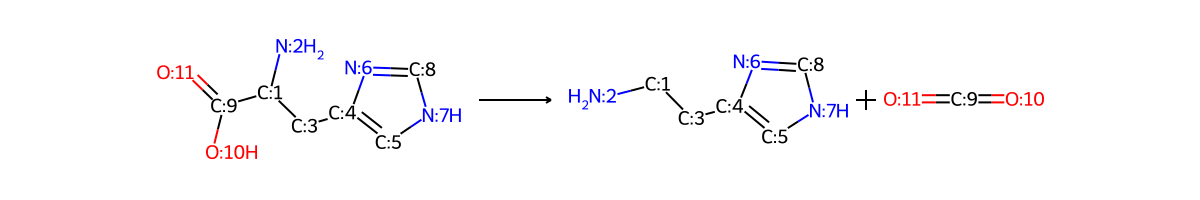

In [6]:
SVG(draw_reaction(mm.loc[mm['entry_id'] == 49, 'am_smarts'].values[0]))

[NH2:2][CH:1]([CH2:3][c:4]1[cH:5][nH:7][cH:8][n:6]1)[C:9](=[O:11])[OH:10]


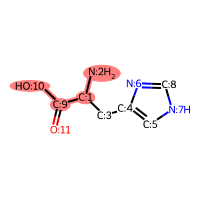

In [7]:
sma = mm.loc[mm['entry_id'] == 49, 'am_smarts'].values[0].split('>>')[0]
print(sma)
mol = Chem.MolFromSmiles(sma)
SVG(draw_molecule(mol, highlight_atoms=[0, 1, 8, 10]))

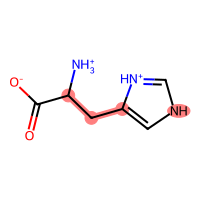

In [8]:
mol = Chem.MolFromSmiles('[NH3+]C(Cc1c[nH]c[nH+]1)C(=O)[O-]')
SVG(draw_molecule(mol, highlight_atoms=[1, 2, 3, 5]))

[NH3+:46][CH:47]([CH2:45][c:55]1[cH:53][nH:51][cH:52][nH+:54]1)[C:49](=[O:48])[O-:50]


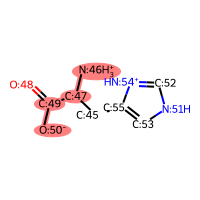

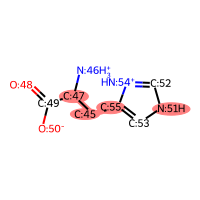

In [9]:
mol = Chem.MolFromSmiles('[CH2:45]([CH:47]([NH3+:46])[C:49](=[O:48])[O-:50])[c:55]1[cH:53][nH:51][cH:52][nH+:54]1')
print(Chem.MolToSmiles(mol, ignoreAtomMapNumbers=True))
display(SVG(draw_molecule(mol, highlight_atoms=[1, 2, 3, 5])))
mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol, ignoreAtomMapNumbers=True))
display(SVG(draw_molecule(mol, highlight_atoms=[1, 2, 3, 5])))


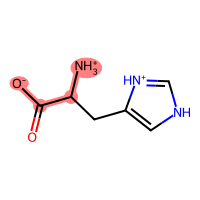

In [10]:
mol = Chem.MolFromSmiles('[NH3+]C(Cc1c[nH]c[nH+]1)C(=O)[O-]')
SVG(draw_molecule(mol, highlight_atoms=[0, 1, 8, 10]))

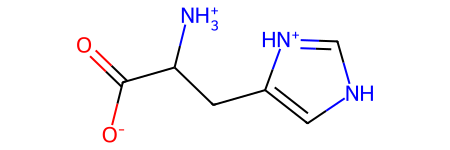

In [11]:
mol = Chem.RemoveHs(mol)
mol

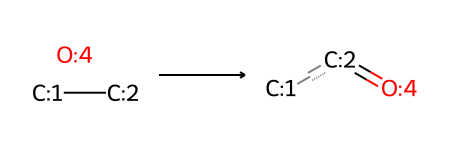

In [12]:
AllChem.ReactionFromSmarts('([C:1]-[C:2].[O:4])>>[C:1]([C:2]=[O:4])')

In [13]:
Chem.MolToSmiles(Chem.MolFromSmiles('[CH3:1][CH2:2][OH:3]'), ignoreAtomMapNumbers=True)

'[CH3:1][CH2:2][OH:3]'

In [14]:
Chem.MolToSmiles(Chem.MolFromSmiles('[CH3][CH2][OH]'))

'CCO'

In [15]:
Chem.MolToSmiles(Chem.MolFromSmiles('[CH3][CH2][OH]'))

'CCO'

In [16]:
Chem.MolToSmarts(Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles('[CH3][CH2][OH]'))))

'[#6]-[#6]-[#8]'

In [17]:
mol = Chem.MolFromSmiles('[CH3:1][CH2:2][OH:3]')
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(0)
Chem.MolToSmarts(Chem.MolFromSmiles(Chem.MolToSmiles(mol)))

'[#6]-[#6]-[#8]'

In [18]:
mol = Chem.MolFromSmiles('[CH3:1][CH2:2][OH:3]')
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(0)

mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx() + 1)

Chem.MolToSmarts(mol)

'[#6:1]-[#6:2]-[#8:3]'

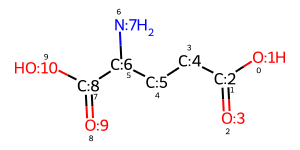

In [19]:
smi = 'OC(=O)CCC(N)C(=O)O'
mol = Chem.MolFromSmiles(smi)
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx() + 1)  # Set AtomMapNum to idx + 1 for each atom
SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True}))

In [20]:
print(Chem.MolFragmentToSmarts(mol, atomsToUse={0, 1, 3, 5, 6}))
print(Chem.MolFragmentToSmarts(mol, atomsToUse={3, 5, 1, 0, 6}))
# print(Chem.MolFragmentToSmiles(mol, atomsToUse={3, 5, 1, 0, 6}))

[#8:1]-[#6:2]-[#6:4].[#6:6]-[#7:7]
[#8:1]-[#6:2]-[#6:4].[#6:6]-[#7:7]


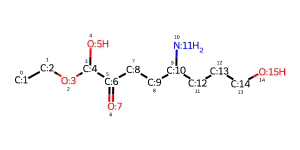

In [68]:
smi = 'CCOC(O)C(=O)CCC(N)CCCO'
mol = Chem.MolFromSmiles(smi)
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx() + 1)  # Set AtomMapNum to idx + 1 for each atom
SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True}))

In [69]:
print(Chem.MolFragmentToSmarts(mol, atomsToUse={14, 13, 12, 10, 9}))

[#6:10]-[#7:11].[#6:13]-[#6:14]-[#8:15]


In [21]:
Chem.GetShortestPath(mol, 3, 5)

(3, 4, 5)

In [22]:
Chem.GetAdjacencyMatrix(mol, useBO=True)[[0, 1, 3, 5, 6]][:, [0, 1, 3, 5, 6]]

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

[16:37:40] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 4 


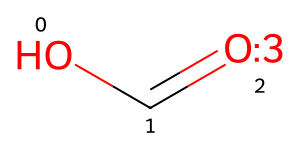

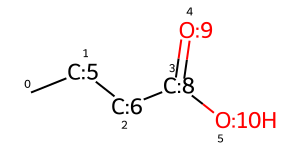

In [23]:
rule = '([O:1]-[C:2]-[C:3].[N:4])>>[O:1]-[C:2].[C:3]'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

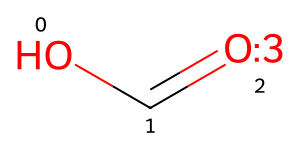

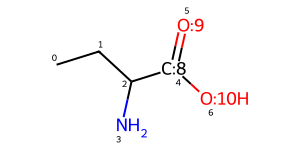

In [24]:
# This looks like the winner
# I will have to be careful about bonds between included atoms
# and not included atoms. Depending on the atomic invariants
# the order of these bonds may be specified and not wildcard
rule = '[O:1]-[C:2]-[C:3]~[*:4]~[*:5]~[N:6]>>[O:1]-[C:2].[C:3]~[*:4]~[*:5]~[N:6]'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

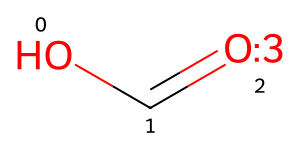

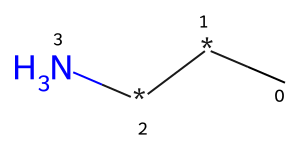

In [25]:
rule = '[O:1]-[C:2]-[C:3]~*~*~[N:6]>>[O:1]-[C:2].[C:3]~*~*~[N:6]'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

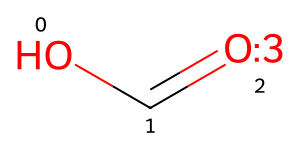

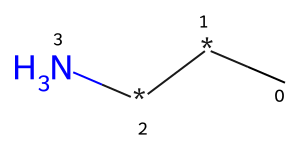

In [26]:
rule = '[O:1]-[C:2]-[C:3]~*~*~N>>[O:1]-[C:2].[C:3]~*~*~N'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

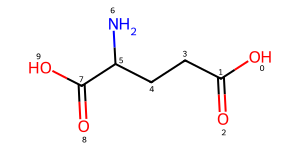

0 0 1 1.0
1 1 2 2.0
2 1 3 1.0
3 3 4 1.0
4 4 5 1.0
5 5 6 1.0
6 5 7 1.0
7 7 8 2.0
8 7 9 1.0


In [27]:
smi = 'OC(=O)CCC(N)C(=O)O'
mol = Chem.MolFromSmiles(smi)
display(SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True})))
for bond in mol.GetBonds():
    print(bond.GetIdx(), bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondTypeAsDouble())

[#8]-[#6](=[#8])-[#0][#0]-[#6](-[#7])-[#6](=[#8])-[#8]


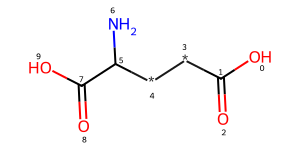

0 0 1 1.0
1 1 2 2.0
2 1 3 1.0
3 3 4 0.0
4 4 5 1.0
5 5 6 1.0
6 5 7 1.0
7 7 8 2.0
8 7 9 1.0


In [28]:
mol.GetAtomWithIdx(3).SetAtomicNum(0)
mol.GetAtomWithIdx(4).SetAtomicNum(0)
mol.GetBondWithIdx(3).SetBondType(Chem.rdchem.BondType.UNSPECIFIED)
smarts = Chem.MolToSmarts(mol)
print(smarts)
display(SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True})))
for bond in mol.GetBonds():
    print(bond.GetIdx(), bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondTypeAsDouble())

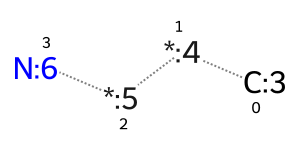

0 0 1 UNSPECIFIED
1 1 2 UNSPECIFIED
2 2 3 UNSPECIFIED


In [29]:
mol = Chem.MolFromSmarts('[C:3]~[*:4]~[*:5]~[N:6]')
display(SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True})))
for bond in mol.GetBonds():
    print(bond.GetIdx(), bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType())

In [30]:
Chem.MolToSmiles(Chem.MolFromSmiles('O.CC'))

'CC.O'

In [31]:
Chem.MolToSmarts(Chem.MolFromSmarts('[#8:1].[#6:2]-[#6:3]'))

'[#8:1].[#6:2]-[#6:3]'

In [32]:
Chem.MolToSmarts(Chem.MolFromSmarts('[#6:2]-[#6:3].[#8:1]'))

'[#6:2]-[#6:3].[#8:1]'

2 0 6
3 1 6
1 2 8


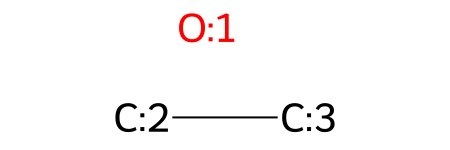

In [33]:
mol = Chem.MolFromSmarts('[#6:2]-[#6:3].[#8:1]')
for atom in mol.GetAtoms():
    print(atom.GetAtomMapNum(), atom.GetIdx(), atom.GetAtomicNum())
    # atom.SetAtomMapNum(atom.GetIdx() + 1)
mol

1 0 8
2 1 6
3 2 6


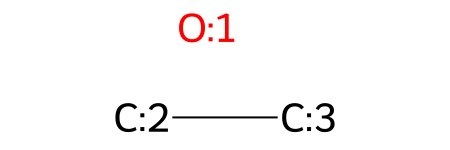

In [34]:
mol = Chem.MolFromSmarts('[#8:1].[#6:2]-[#6:3]')
for atom in mol.GetAtoms():
    print(atom.GetAtomMapNum(), atom.GetIdx(), atom.GetAtomicNum())
    atom.SetAtomMapNum(atom.GetIdx() + 1)
mol

0 6
1 6
2 8


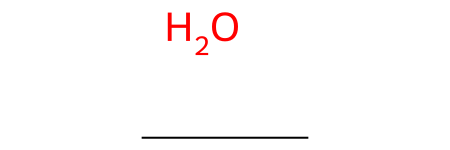

In [35]:
combo1 = Chem.CombineMols(Chem.MolFromSmiles('CC'), Chem.MolFromSmiles('O'))
for atom in combo1.GetAtoms():
    print(atom.GetIdx(), atom.GetAtomicNum())
combo1

0 8
1 6
2 6


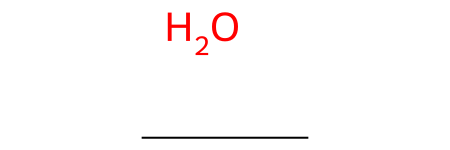

In [36]:
combo2 = Chem.CombineMols(Chem.MolFromSmiles('O'), Chem.MolFromSmiles('CC'))
for atom in combo2.GetAtoms():
    print(atom.GetIdx(), atom.GetAtomicNum())
combo2

0 8
1 8
2 6
3 6
4 6
5 7
6 6


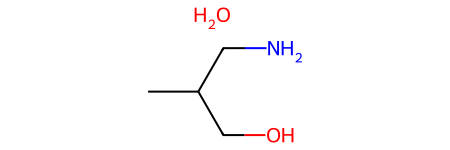

In [37]:
combo3 = Chem.CombineMols(Chem.MolFromSmiles('O'), Chem.MolFromSmiles('OCC(CN)C'))
for atom in combo3.GetAtoms():
    print(atom.GetIdx(), atom.GetAtomicNum())
combo3

In [38]:
Chem.GetShortestPath(combo3, 4, 5)

(4, 5)

In [39]:
mol = Chem.MolFromSmiles('OCC')
for atom in mol.GetAtoms():
    print(atom.GetIdx(), atom.GetAtomicNum())

0 8
1 6
2 6


In [40]:
Chem.MolToSmiles(Chem.MolFromSmiles('OCC'))

'CCO'

In [41]:
import numpy as np

In [42]:
foo = np.array([1, 2, 1.5])
(foo == foo).all(), foo.dtype

(np.True_, dtype('float64'))

In [43]:
A = np.array(
    [
        [0, 2, 0],
        [1, 0, 1],
        [0, 3, 0],

    ]
)

print(A)
print(A @ A)
print(A @ A @ A)

[[0 2 0]
 [1 0 1]
 [0 3 0]]
[[2 0 2]
 [0 5 0]
 [3 0 3]]
[[ 0 10  0]
 [ 5  0  5]
 [ 0 15  0]]


In [44]:
import networkx as nx

In [45]:
G = nx.from_numpy_array(A)
k = 3
k_hop_subgraphs = set()
for i in range(0, k):
    for n in range(3):
        k_hop_subgraphs.add(tuple(nx.ego_graph(G, n, radius=i).nodes))

In [46]:
k_hop_subgraphs

{(0,), (0, 1), (0, 1, 2), (1,), (1, 2), (2,)}

In [47]:
a = [1, 5, 1, 4, 3, 4, 4]  # First sequence
b = [9, 4, 0, 4, 0, 2, 1]

arr = np.array([b, a])
np.lexsort(arr)

array([2, 0, 4, 6, 5, 3, 1])

In [48]:
arr.shape

(2, 7)

In [49]:
from itertools import product

In [50]:
list(
    product(
        [(0, 1)],
        [(2, 3), (3, 2)],
        [(4, 5, 6)]
    )
)

[((0, 1), (2, 3), (4, 5, 6)), ((0, 1), (3, 2), (4, 5, 6))]

In [51]:
from itertools import permutations

list(permutations([1, 2, 3]))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

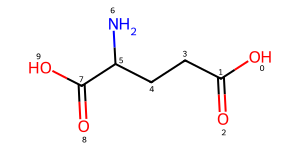

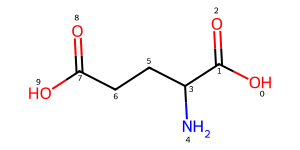

SP3
SP3


In [52]:
smi = 'OC(=O)CCC(N)C(=O)O'
mol = Chem.MolFromSmiles(smi)

smi2 = "OC(=O)C(N)CCC(=O)O"
mol2 = Chem.MolFromSmiles(smi2)

display(SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True})))
display(SVG(draw_molecule(mol2, size=(300, 150), draw_options={"addAtomIndices": True})))
print(mol.GetAtomWithIdx(5).GetHybridization())
print(mol.GetAtomWithIdx(4).GetHybridization())

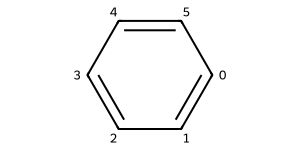

rdkit.Chem.rdchem.HybridizationType.SP2

In [53]:
benzene = Chem.MolFromSmiles('c1ccccc1')
display(SVG(draw_molecule(benzene, size=(300, 150), draw_options={"addAtomIndices": True})))
benzene.GetAtomWithIdx(0).GetHybridization()

In [54]:
benzene.GetAtomWithIdx(0).GetSmarts(doKekule=False, allHsExplicit=True)

'[cH]'

In [55]:
benzene.GetAtomWithIdx(0).GetSymbol()

'C'

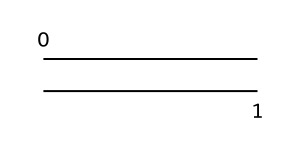

rdkit.Chem.rdchem.HybridizationType.SP2

In [56]:
ethene = Chem.MolFromSmiles('C=C')
display(SVG(draw_molecule(ethene, size=(300, 150), draw_options={"addAtomIndices": True})))
ethene.GetAtomWithIdx(0).GetHybridization()

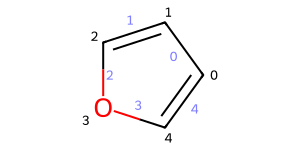

rdkit.Chem.rdchem.BondType.AROMATIC

In [57]:
furan = Chem.MolFromSmiles('c1ccoc1')
display(SVG(draw_molecule(furan, size=(300, 150), draw_options={"addAtomIndices": True, "addBondIndices": True})))
furan.GetAtomWithIdx(3).GetHybridization()
furan.GetBondWithIdx(0).GetBondType()

In [58]:
furan.GetBondWithIdx(4).GetSmarts(allBondsExplicit=True)

':'

In [59]:
tuple(i for i in range(5))

(0, 1, 2, 3, 4)

In [60]:
Chem.MolFromSmiles('O=C(O)c1nc(O)ccn1').GetSubstructMatches(Chem.MolFromSmarts('[O]=[Cz2H0v4D3&0]'))

((0, 1),)

In [61]:
Chem.MolFromSmiles('C').GetAtomWithIdx(0).GetDegree()

0

In [62]:
Chem.MolFromSmiles('C').GetSubstructMatches(Chem.MolFromSmarts('[D1]'))

()